In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
cpu_load_df = pd.read_csv(
    "/content/drive/MyDrive/TimeSeries/cpu_load.csv",
    parse_dates=True,
    index_col='timestamp'
    )

In [4]:
cpu_load_df

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


<Axes: xlabel='timestamp'>

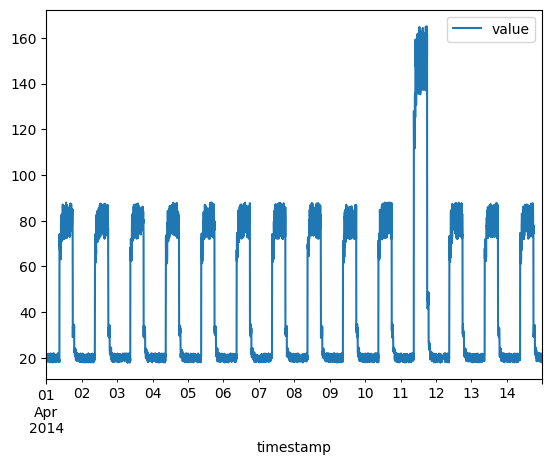

In [5]:
cpu_load_df.plot()

## 1. 정상 데이터를 구할 수 있는 경우
  1.1 말그대로 정상 샘플
  
  1.2 이상치가 포함된 데이터에서 알고 있던 이상치 (Known Anomaly)를 제거

In [6]:
cpu_load_normal_df = pd.read_csv(
    "/content/drive/MyDrive/TimeSeries/cpu_load_normal.csv",
    parse_dates=True,
    index_col='timestamp'
    )

<Axes: xlabel='timestamp'>

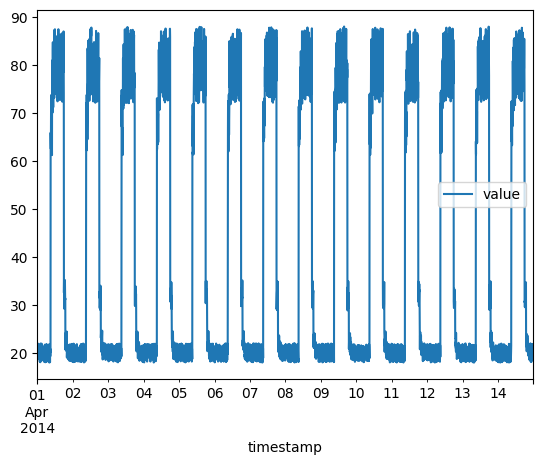

In [7]:
cpu_load_normal_df.plot()

## 데이터 전처리

In [26]:
training_mean = cpu_load_df.mean()
training_std = cpu_load_df.std()
df_training_value = (cpu_load_df - training_mean) / training_std # z-score 정규화

# training_mean = cpu_load_normal_df.mean()
# training_std = cpu_load_normal_df.std()
# df_training_value = (cpu_load_normal_df - training_mean) / training_std # z-score 정규화

## Blocked CV 형식으로 데이터 분할

In [27]:
# Blocked Crossvalidation
TIME_STEPS = 288 # 1440분 => 하루

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# AutoEncoder, x=y
x_train = create_sequences(df_training_value.values)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


In [28]:
x_train.shape

(3744, 288, 1)

In [29]:
# CNN 기반 모델
model = keras.Sequential(
    [                         # 288,                1
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])), # 288, 1
        # 요약한 정보를 32차원으로 바꾸고, 7개의 window를 보고, 2개 중에서 pooling을 하겠다.
        # MaxPooling, AveragePooling
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 144, 32
        ),
        layers.Dropout(rate=0.2),
        # 요약한 정보를 16차원으로 바꾸고, 7개의 window를 보고, 2개 중에서 pooling을 하겠다
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 72, 16
        ),
        layers.Conv1D(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 36, 8
        ),
        layers.Conv1D(
              filters=4, kernel_size=7, padding="same", strides=2, activation="relu" # 18, 4 <= z vector / Encoder 끝.
          ),
        # Decoder 시작
        layers.Conv1DTranspose(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 36, 8
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 72, 16
        ),
        layers.Dropout(rate=0.2),
        # 32차원으로 7개의 윈도우를 봐서, stride=2이므로, 시계열이 2배로 확장.
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 144, 32
        ),
          layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu" # 288, 32
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"), # 288, 1, 원본 시계열.
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_6 (Conv1D)           (None, 36, 8)             904       
                                                                 
 conv1d_7 (Conv1D)           (None, 18, 4)             228       
                                                                 
 conv1d_transpose_5 (Conv1DT  (None, 36, 8)            232       
 ranspose)                                                       
                                                      

In [30]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128
)

Epoch 1/50
30/30 [==============================] - 4s 9ms/step - loss: 0.7426
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.2545
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0951
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0707
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.0580
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.0488
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0427
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0380
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0349
Epoch 10/50
30/30 [==============================] - 0s 6ms/step - loss: 0.0324
Epoch 11/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0308
Epoch 12/50
30/30 [==============================] - 0s 7ms/step - loss: 0.0294
Epoch 13/50
30/30 [=============================

In [31]:
x_train_pred = model.predict(x_train)

117/117 [==============================] - 0s 2ms/step


In [32]:
x_train_pred.shape

(3744, 288, 1)

## 학습 데이터를 그대로 복원  => 복원된 데이터와 학습 데이터를 비교

## 이상치 포함

117/117 [==============================] - 0s 3ms/step


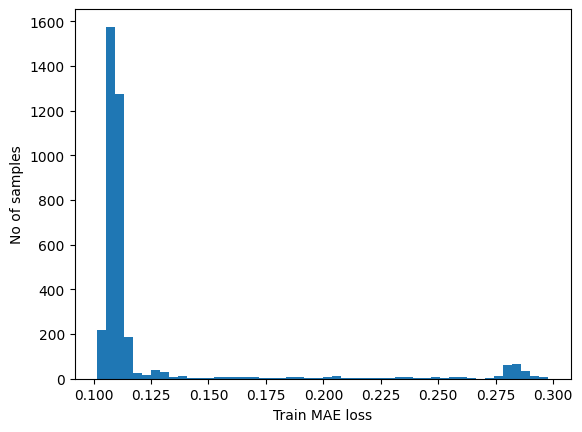

Reconstruction error threshold:  0.2


In [34]:
x_train_pred = model.predict(x_train)
                          # 예측값 각각에 대한 mean absoulte err
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss) * 1 # 학습 데이터의 최대 에러의 95% 수준보다 넘어가는건 이상치다.
# threshold = np.max(train_mae_loss) * 1.2 # outlia
threshold = 0.2
print("Reconstruction error threshold: ", threshold)

## 이상치 포함 X

In [35]:
anomalies = train_mae_loss > threshold # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  282
Indices of anomaly samples:  (array([2755, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766,
       2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
       2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799,
       2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810,
       2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821,
       2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832,
       2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843,
       2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854,
       2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865,
       2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876,
       2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887,
       2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2

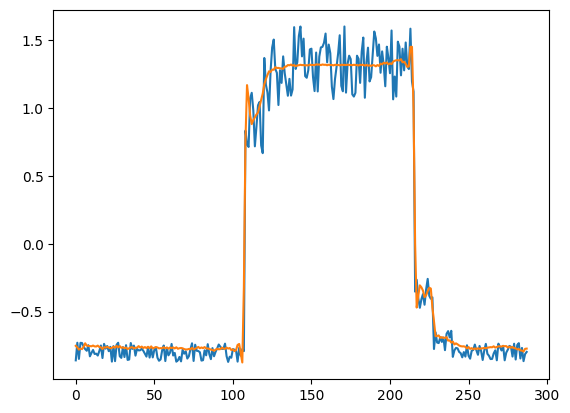

In [18]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [19]:
df_test_value = (cpu_load_df - training_mean) / training_std

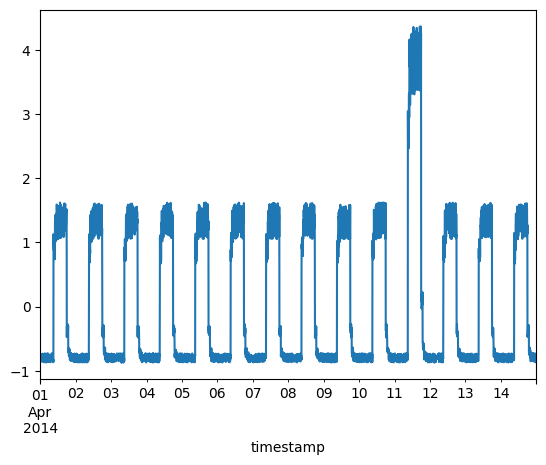

Test input shape:  (3744, 288, 1)
117/117 [==============================] - 0s 2ms/step


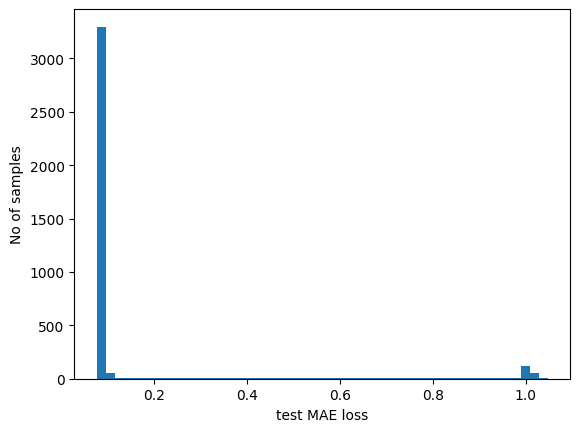

Number of anomaly samples:  403
Indices of anomaly samples:  (array([2522, 2523, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709,
       2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720,
       2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742,
       2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753,
       2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
       2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
       2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786,
       2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797,
       2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808,
       2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819,
       2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2

In [20]:
df_test_value = (cpu_load_df - training_mean) / training_std

fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss_total = np.abs(x_test_pred - x_test)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [21]:
test_mae_loss_total

array([[[0.05634941],
        [0.01780739],
        [0.02106984],
        ...,
        [0.05561756],
        [0.07195992],
        [0.09012662]],

       [[0.03001531],
        [0.03703989],
        [0.03331058],
        ...,
        [0.05329281],
        [0.09164057],
        [0.03006715]],

       [[0.04865905],
        [0.01782749],
        [0.01267473],
        ...,
        [0.07208214],
        [0.02762163],
        [0.02372842]],

       ...,

       [[0.00051977],
        [0.05801623],
        [0.02694368],
        ...,
        [0.02805128],
        [0.09389242],
        [0.00956882]],

       [[0.066114  ],
        [0.04058593],
        [0.00015762],
        ...,
        [0.07381889],
        [0.00982345],
        [0.00696066]],

       [[0.05233454],
        [0.01675967],
        [0.07851014],
        ...,
        [0.03069849],
        [0.0047808 ],
        [0.08796704]]])

In [22]:
len(df_test_value)

4032

In [23]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [24]:
anomalous_data_indices

[2988,
 2989,
 2990,
 2991,
 2992,
 2993,
 2994,
 2995,
 2996,
 2997,
 2998,
 2999,
 3000,
 3001,
 3002,
 3003,
 3004,
 3005,
 3006,
 3007,
 3008,
 3009,
 3010,
 3011,
 3012,
 3013,
 3014,
 3015,
 3016,
 3017,
 3018,
 3019,
 3020,
 3021,
 3022,
 3023,
 3024,
 3025,
 3026,
 3027,
 3028,
 3029,
 3030,
 3031,
 3032,
 3033,
 3034,
 3035,
 3036,
 3037,
 3038,
 3039,
 3040,
 3041,
 3042,
 3043,
 3044,
 3045,
 3046,
 3047,
 3048,
 3049,
 3050,
 3051,
 3052,
 3053,
 3054,
 3055,
 3056,
 3057,
 3058,
 3059,
 3060,
 3061,
 3062,
 3063,
 3064,
 3065,
 3066,
 3067,
 3068,
 3069,
 3070,
 3071,
 3072,
 3073,
 3074,
 3075,
 3076,
 3077,
 3078,
 3079,
 3080,
 3081,
 3082,
 3083,
 3084,
 3085,
 3086,
 3087,
 3088,
 3089,
 3090,
 3091,
 3092,
 3093,
 3094,
 3095,
 3096,
 3097,
 3098,
 3099,
 3100,
 3101,
 3102]

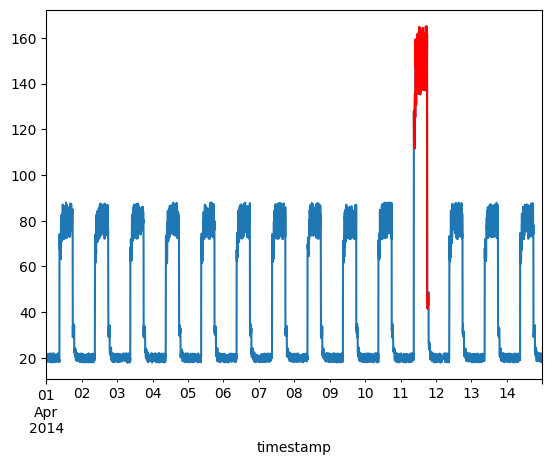

In [25]:
df_subset = cpu_load_df.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
cpu_load_df.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()